In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate,Dot
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
import tensorflow.data
from tensorflow.keras.regularizers import L2
from joblib import load
import pydot
from datetime import datetime
from thefuzz import process

In [2]:
@tf.keras.utils.register_keras_serializable()
def split_func(input_str):
  return tf.strings.split(input_str, sep=", ")

In [3]:

studio_vectorize_layer_model=tf.keras.models.load_model('intermediate_data_all_embeddings/studio_vectorize_layer_model')
studio_vectorize_layer = studio_vectorize_layer_model.layers[0]

num_studios=len(studio_vectorize_layer.get_vocabulary())
num_studios

914

In [4]:
genre_vectorize_layer_model=tf.keras.models.load_model('intermediate_data_all_embeddings/genre_vectorize_layer_model')
genre_vectorize_layer = genre_vectorize_layer_model.layers[0]

num_genres=len(genre_vectorize_layer.get_vocabulary())
num_genres

23

In [5]:
source_vectorize_layer_model=tf.keras.models.load_model('intermediate_data_all_embeddings/source_vectorize_layer_model')
source_vectorize_layer = source_vectorize_layer_model.layers[0]


num_sources=len(source_vectorize_layer.get_vocabulary())
num_sources

19

In [6]:
user_input_shape=6

In [7]:
anime_input_shape=8

In [8]:
studio_max_length = 10

In [9]:
genre_max_length=9

In [10]:
source_max_length=1

In [2]:
df=np.load('F:/merged.npy',mmap_mode='r+')

In [3]:
df[0]

memmap([ 1.4194900e+05,  2.0000000e+01,  1.2018528e+00, -2.4250230e-01,
         3.2000000e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  1.8112249e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  9.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         3.0000000e+00,  5.0000000e+00,  2.0000000e+00,  2.5000000e+01,
         3.1000000e+01,  8.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  2.0000000e+00], dtype=float32)

In [4]:
df

memmap([[ 1.4194900e+05,  2.0000000e+01,  1.2018528e+00, ...,
          0.0000000e+00,  0.0000000e+00,  2.0000000e+00],
        [ 3.3784000e+05,  5.3560000e+03,  9.4899648e-01, ...,
          0.0000000e+00,  0.0000000e+00,  5.0000000e+00],
        [ 1.8695600e+05,  9.2600000e+03, -1.1260273e+00, ...,
          0.0000000e+00,  0.0000000e+00,  7.0000000e+00],
        ...,
        [ 3.5065600e+05,  1.5750000e+03,  1.0801682e+00, ...,
          0.0000000e+00,  0.0000000e+00,  3.0000000e+00],
        [ 1.8338100e+05,  3.7450000e+04,  1.2018528e+00, ...,
          0.0000000e+00,  0.0000000e+00,  7.0000000e+00],
        [ 5.3598000e+04,  1.6011000e+04,  4.7535399e-01, ...,
          0.0000000e+00,  0.0000000e+00,  7.0000000e+00]], dtype=float32)

In [12]:
np.random.shuffle(df)

In [14]:
size=df.shape[0]

In [15]:
dfhalf1=df[0:int(size/2),:]

In [16]:
dfhalf1.shape

(29984240, 38)

In [17]:
np.save('F:/merged_half1.npy',dfhalf1)

In [18]:
dfhalf2=df[int(size/2):,:]

In [19]:
dfhalf2.shape

(29984240, 38)

In [20]:
np.save('F:/merged_half2.npy',dfhalf2)

In [24]:
df.shape

(59968480, 38)

In [11]:
df=np.load('F:/merged_half1.npy')

In [11]:
df=np.load('intermediate_data_all_embeddings/merged.npy')

In [13]:
user_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,3:9])
anime_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,9:9+anime_input_shape])
anime_studio_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape:9+anime_input_shape+studio_max_length])
anime_genre_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape+studio_max_length:9+anime_input_shape+studio_max_length+genre_max_length])
anime_source_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,-1:])
ratings_dataset = tf.data.Dataset.from_tensor_slices(df[:,2])

In [14]:
dataset = tf.data.Dataset.zip(({'user_input':user_metadata_dataset, 'anime_input':anime_metadata_dataset,'anime_genre_embedding_input':anime_genre_embedding_dataset,'anime_studio_embedding_input':anime_studio_embedding_dataset,'anime_source_embedding_input':anime_source_embedding_dataset}, ratings_dataset))


In [14]:
# Take one element from the dataset
sample_row = next(iter(dataset.take(1)))

# Print the sample row
print("Sample Row:", sample_row)

Sample Row: ({'user_input': <tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-0.2425023, 32.       ,  0.       ,  0.       ,  0.       ,
        1.       ], dtype=float32)>, 'anime_input': <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([1.8112249, 0.       , 0.       , 0.       , 0.       , 0.       ,
       1.       , 0.       ], dtype=float32)>, 'anime_genre_embedding_input': <tf.Tensor: shape=(13,), dtype=float32, numpy=
array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  5.,  2., 25., 31.,  8.],
      dtype=float32)>, 'anime_studio_embedding_input': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, 'anime_source_embedding_input': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>}, <tf.Tensor: shape=(), dtype=float32, numpy=1.2018528>)


In [15]:
size = dataset.cardinality().numpy()

In [16]:
size

23793954

In [17]:
#dataset=dataset.shuffle(int(size ))
train_size = int(0.99 * size)  # Assuming an 80-10-10 split
val_size =int(0.005*size)
train_dataset = dataset.take(train_size)    
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset1 = dataset.skip(train_size).skip(val_size)


In [18]:
batch_size = 8192
val_dataset=val_dataset.shuffle(batch_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
val_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=15>

In [20]:
batch_size = 8192
train_dataset=train_dataset.shuffle(batch_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=2876>

In [22]:
def user_model(input_shape):
    input=Input(shape=(input_shape))
    x=Dense(256,activation='relu', kernel_regularizer=L2())(input)
    x=Dense(128,activation='relu',kernel_regularizer=L2())(x)
    x=Dense(64,activation='relu',kernel_regularizer=L2())(x)
    output=Dense(16,activation='relu',kernel_regularizer=L2())(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
    
    
    


In [23]:
def anime_model(input_shape):
    input = Input(shape=(input_shape,),name='anime_inputs')
    input_genre= Input(shape=(genre_max_length,),name='anime_genre_embeddings_inputs')
    input_studio= Input(shape=(studio_max_length,),name='anime_studio_embeddings_inputs')
    input_source= Input(shape=(source_max_length,),name='anime_source_embeddings_inputs')
    genre_embedding=tf.keras.layers.Embedding(input_dim=num_genres,output_dim=16,mask_zero=True)(input_genre)
    genre_flattened = tf.keras.layers.Flatten()(genre_embedding)
    studio_embedding=tf.keras.layers.Embedding(input_dim=num_studios,output_dim=16,mask_zero=True)(input_studio)
    studio_flattened = tf.keras.layers.Flatten()(studio_embedding)
    source_embedding=tf.keras.layers.Embedding(input_dim=num_sources,output_dim=16,mask_zero=True)(input_source)
    source_flattened = tf.keras.layers.Flatten()(source_embedding)
    x=Concatenate()([input,genre_flattened,studio_flattened,source_flattened])
    x=Dense(128,activation='relu', kernel_regularizer=L2())(x)
    x=Dense(64,activation='relu', kernel_regularizer=L2())(x)
    x=Dense(32,activation='relu',kernel_regularizer=L2())(x)
    output=Dense(16,activation='relu',kernel_regularizer=L2())(x)
    model=Model(inputs=[input,input_genre,input_studio,input_source],outputs=output)
    return model


In [24]:
def merge_models(model_1, model_2, user_input_shape , anime_input_shape):
    user_inputs = tf.keras.Input(shape=(user_input_shape,),name='user_input')
    anime_inputs=tf.keras.Input(shape=(anime_input_shape,),name='anime_input')
    anime_genre_embeddings_inputs=tf.keras.Input(shape=(genre_max_length),name='anime_genre_embedding_input')
    anime_studio_embeddings_inputs=tf.keras.Input(shape=(studio_max_length),name='anime_studio_embedding_input')
    anime_source_embeddings_inputs=tf.keras.Input(shape=(source_max_length),name='anime_source_embedding_input')
    output_1 = model_1(user_inputs)
    output_2 = model_2([anime_inputs,anime_genre_embeddings_inputs,anime_studio_embeddings_inputs,anime_source_embeddings_inputs])
    merged = Dot(1)([output_1, output_2])
    
    x=Dense(128,activation='relu',kernel_regularizer=L2())(merged)
    x=Dense(64,activation='relu',kernel_regularizer=L2())(x)
    x=Dense(32,activation='relu',kernel_regularizer=L2())(x)
    x=Dense(16,activation='relu',kernel_regularizer=L2())(x)
    x=Dense(8,activation='relu',kernel_regularizer=L2())(x)
    
    outputs = Dense(1,activation='linear',kernel_regularizer=L2())(x)
    model = tf.keras.Model(inputs=[user_inputs,anime_inputs,anime_genre_embeddings_inputs,anime_studio_embeddings_inputs,anime_source_embeddings_inputs], outputs=outputs)
    return model

In [25]:
model1=user_model(user_input_shape)
model2=anime_model(anime_input_shape)
model3=merge_models(model1,model2,user_input_shape,anime_input_shape)

In [26]:
model2.get_weights()

[array([[-0.03859358,  0.03120619,  0.01669252,  0.01421257,  0.03238881,
         -0.03648619, -0.04362389,  0.02621516,  0.00982618,  0.00196366,
         -0.00996666,  0.03776512,  0.00307286, -0.04068758,  0.01952979,
          0.01130057],
        [-0.02759284, -0.00659209, -0.03319788,  0.03271136,  0.04459237,
         -0.01317347, -0.00898618,  0.0007251 ,  0.03904131, -0.04609065,
          0.03335   , -0.01949071, -0.04397793,  0.0083593 , -0.03866715,
          0.00885222],
        [ 0.00270091, -0.01854237, -0.04013149,  0.04036612,  0.01356712,
          0.02959293, -0.02860025,  0.00895   ,  0.0196661 , -0.04588974,
         -0.01147391, -0.0357592 ,  0.02942184, -0.02753288,  0.03859853,
         -0.04610577],
        [-0.04712341,  0.00459114,  0.03217422,  0.01926091,  0.04220441,
         -0.04388254, -0.01931224,  0.00675852,  0.03050811,  0.02968195,
          0.02381678, -0.00666755,  0.01960338,  0.04762999,  0.02542111,
          0.00632729],
        [-0.02405121

In [27]:
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [28]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
Total params: 43,984
Trainable params: 43,984
Non-trainable params: 0
_________________________________________________________________


In [29]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anime_genre_embeddings_inputs   [(None, 9)]         0           []                               
 (InputLayer)                                                                                     
                                                                                                  
 anime_studio_embeddings_inputs  [(None, 10)]        0           []                               
  (InputLayer)                                                                                    
                                                                                                  
 anime_source_embeddings_inputs  [(None, 1)]         0           []                               
  (InputLayer)                                                                              

In [30]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 anime_input (InputLayer)       [(None, 8)]          0           []                               
                                                                                                  
 anime_genre_embedding_input (I  [(None, 9)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 anime_studio_embedding_input (  [(None, 10)]        0           []                         

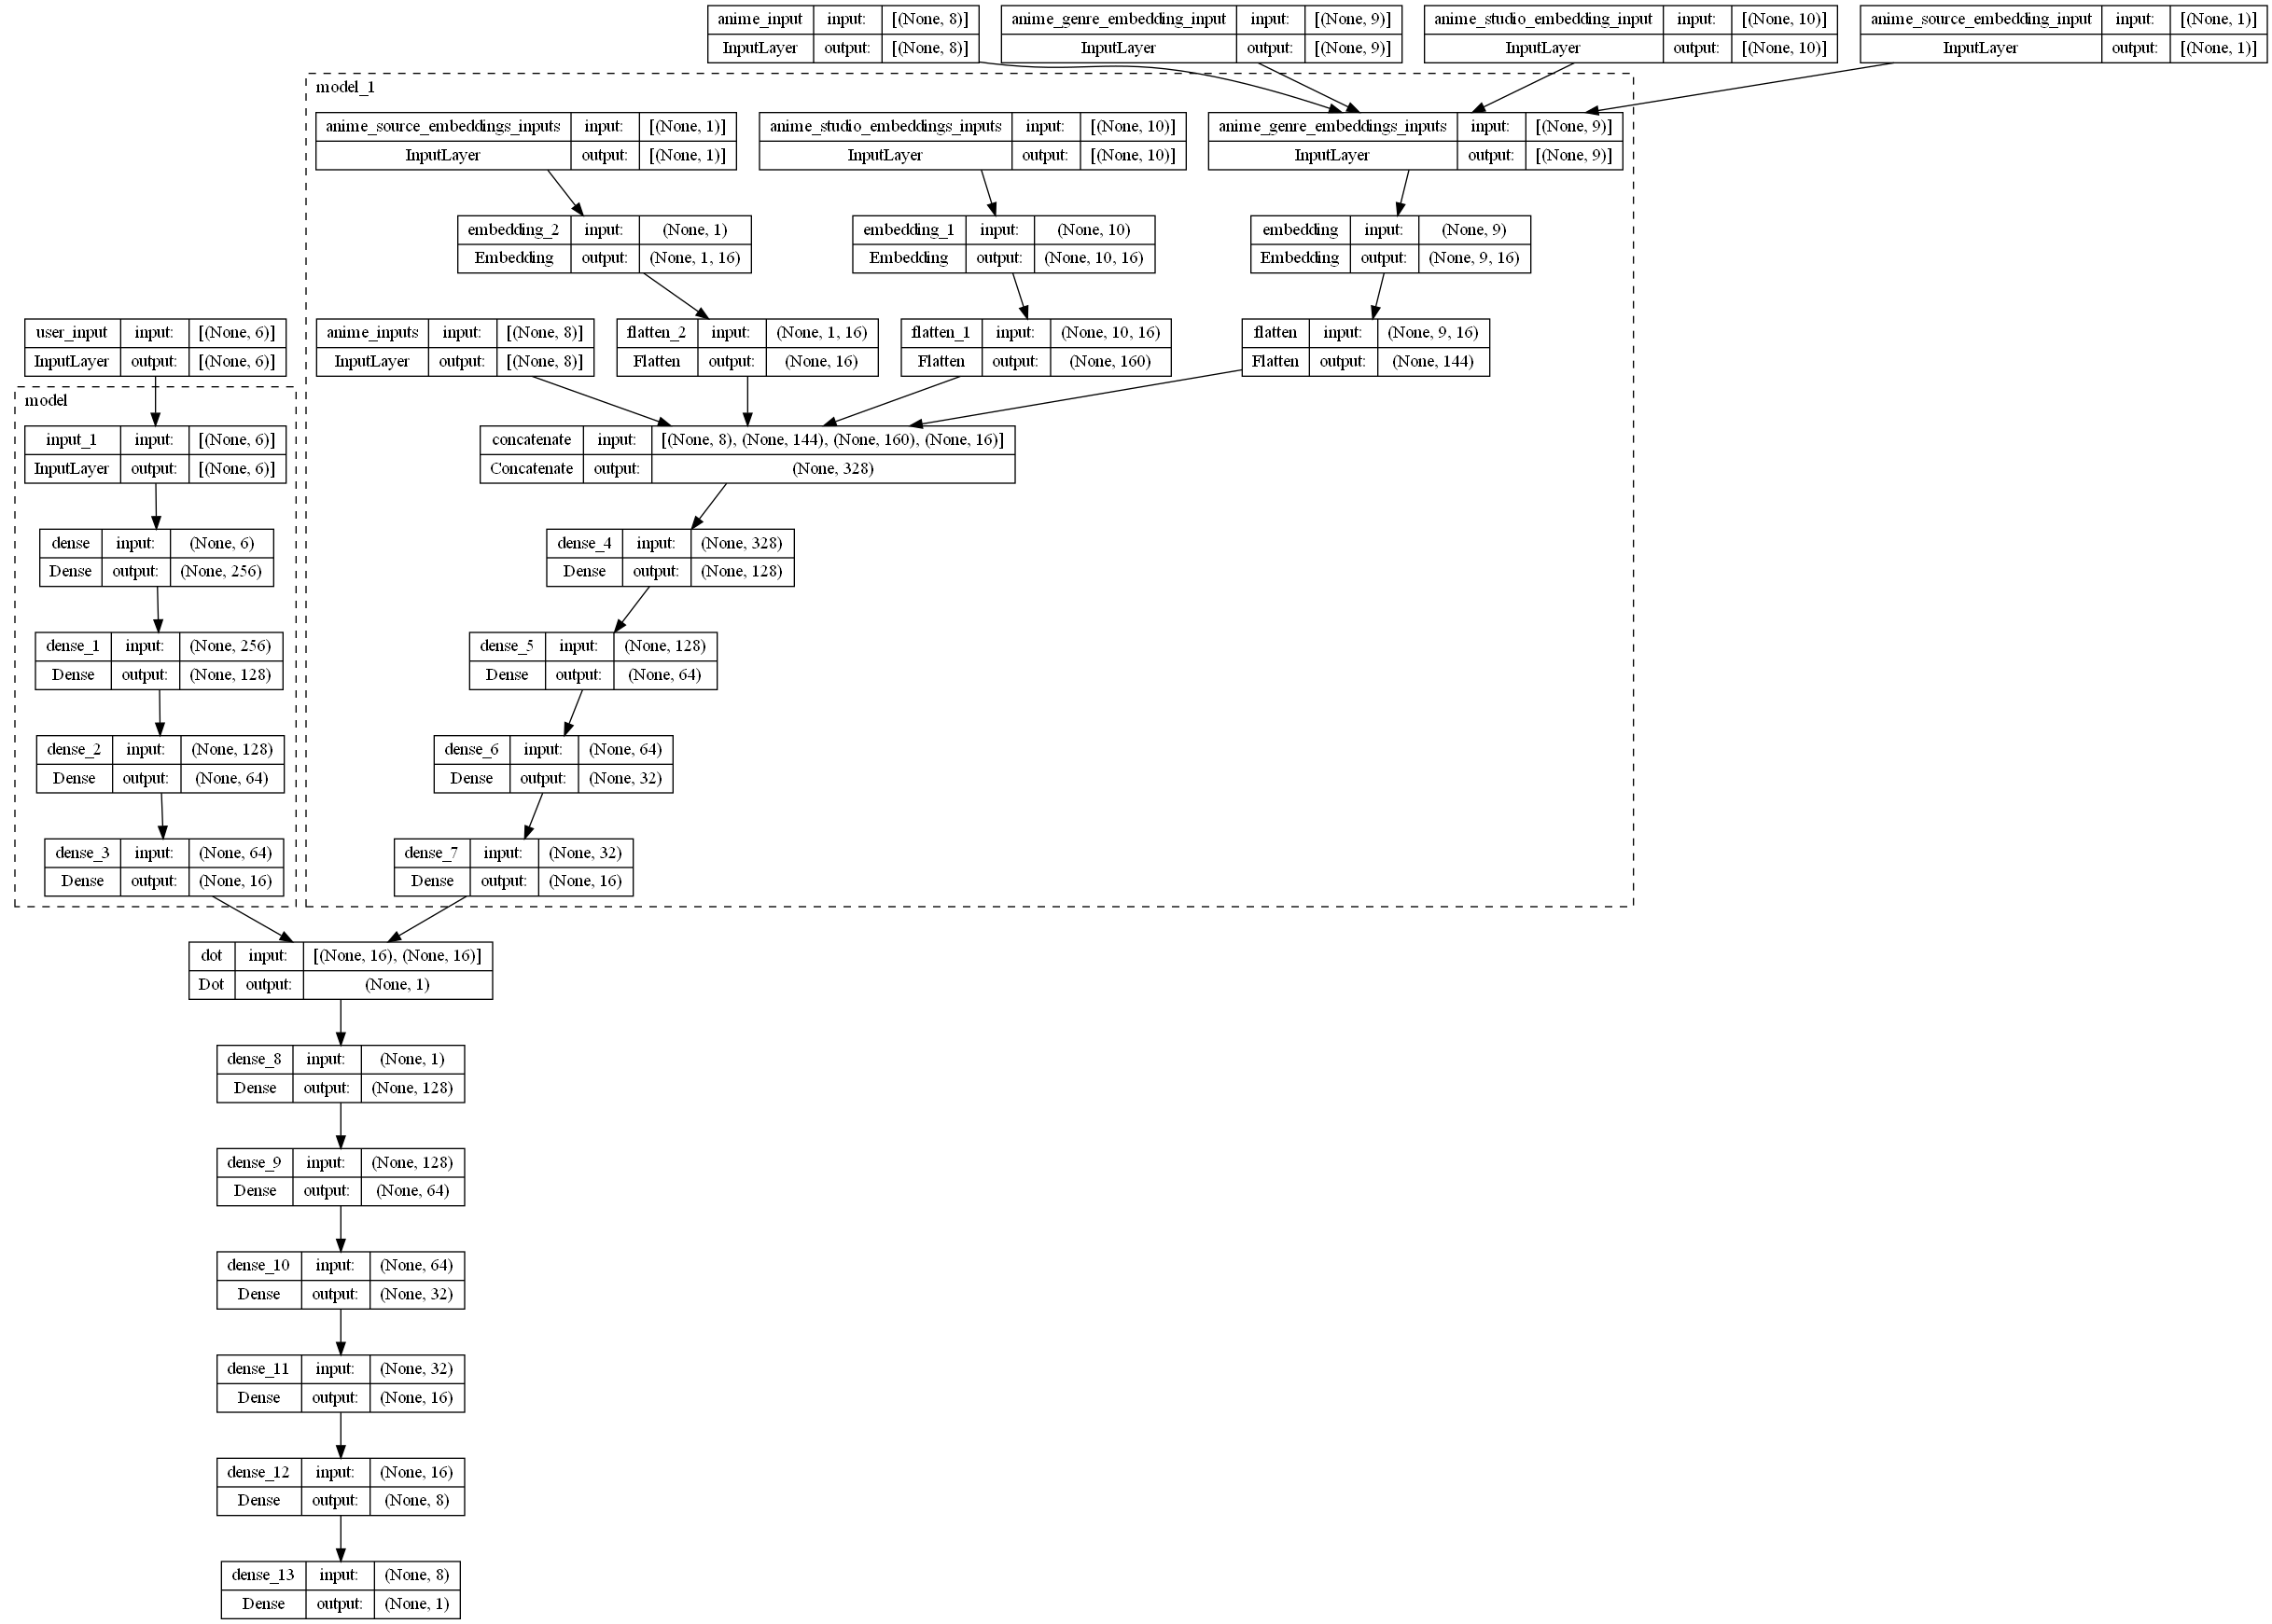

In [31]:
import pydot
import pydotplus
import graphviz
tf.keras.utils.plot_model(
model3,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
)


In [32]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [33]:

history=model3.fit(train_dataset, epochs=6,validation_data=val_dataset)

Epoch 1/6
2876/2876 [==============================] - 290s 100ms/step - loss: 0.8963 - mae: 0.6290 - val_loss: 0.7233 - val_mae: 0.6167
Epoch 2/6
2876/2876 [==============================] - 290s 101ms/step - loss: 0.7172 - mae: 0.6165 - val_loss: 0.7111 - val_mae: 0.6143
Epoch 3/6
2876/2876 [==============================] - 280s 97ms/step - loss: 0.7115 - mae: 0.6157 - val_loss: 0.7096 - val_mae: 0.6157
Epoch 4/6
2876/2876 [==============================] - 294s 102ms/step - loss: 0.7085 - mae: 0.6154 - val_loss: 0.7062 - val_mae: 0.6151
Epoch 5/6
2876/2876 [==============================] - 289s 101ms/step - loss: 0.7065 - mae: 0.6152 - val_loss: 0.7036 - val_mae: 0.6143
Epoch 6/6
2876/2876 [==============================] - 281s 98ms/step - loss: 0.7050 - mae: 0.6150 - val_loss: 0.7059 - val_mae: 0.6150


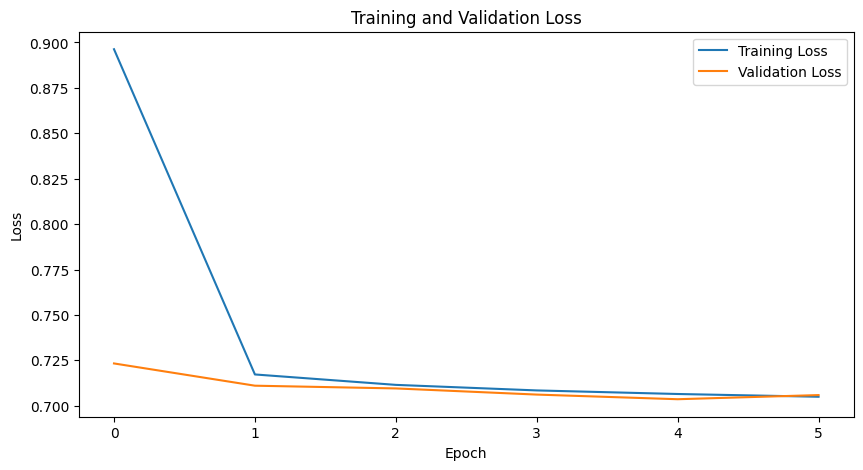

In [34]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
df=np.load('F:/merged_half2.npy')

In [35]:
user_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,3:9])
anime_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,9:9+anime_input_shape])
anime_studio_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape:9+anime_input_shape+studio_max_length])
anime_genre_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape+studio_max_length:9+anime_input_shape+studio_max_length+genre_max_length])
anime_source_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,-1:])
ratings_dataset = tf.data.Dataset.from_tensor_slices(df[:,2])

In [36]:
dataset = tf.data.Dataset.zip(({'user_input':user_metadata_dataset, 'anime_input':anime_metadata_dataset,'anime_genre_embedding_input':anime_genre_embedding_dataset,'anime_studio_embedding_input':anime_studio_embedding_dataset,'anime_source_embedding_input':anime_source_embedding_dataset}, ratings_dataset))


In [37]:
size = dataset.cardinality().numpy()

In [38]:
size

29984240

In [39]:
#dataset=dataset.shuffle(int(size ))
train_size = int(0.99 * size)  # Assuming an 80-10-10 split
val_size =int(0.005*size)
train_dataset = dataset.take(train_size)    
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset2 = dataset.skip(train_size).skip(val_size)


In [40]:
batch_size = 4096
val_dataset=val_dataset.shuffle(batch_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
val_dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset element_spec=({'user_input': TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), 'anime_input': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), 'anime_genre_embedding_input': TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), 'anime_studio_embedding_input': TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), 'anime_source_embedding_input': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>>

In [42]:
batch_size = 4096
train_dataset=train_dataset.shuffle(batch_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
train_dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset element_spec=({'user_input': TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), 'anime_input': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), 'anime_genre_embedding_input': TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), 'anime_studio_embedding_input': TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), 'anime_source_embedding_input': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>>

In [44]:

history=model3.fit(train_dataset, epochs=3,validation_data=val_dataset)

Epoch 1/3
7248/7248 [==============================] - 332s 46ms/step - loss: 0.9951 - mae: 0.9417 - val_loss: 0.9923 - val_mae: 0.9428
Epoch 2/3
7248/7248 [==============================] - 330s 46ms/step - loss: 0.9924 - mae: 0.9411 - val_loss: 0.9899 - val_mae: 0.9410
Epoch 3/3
7248/7248 [==============================] - 332s 46ms/step - loss: 0.9906 - mae: 0.9407 - val_loss: 0.9884 - val_mae: 0.9400


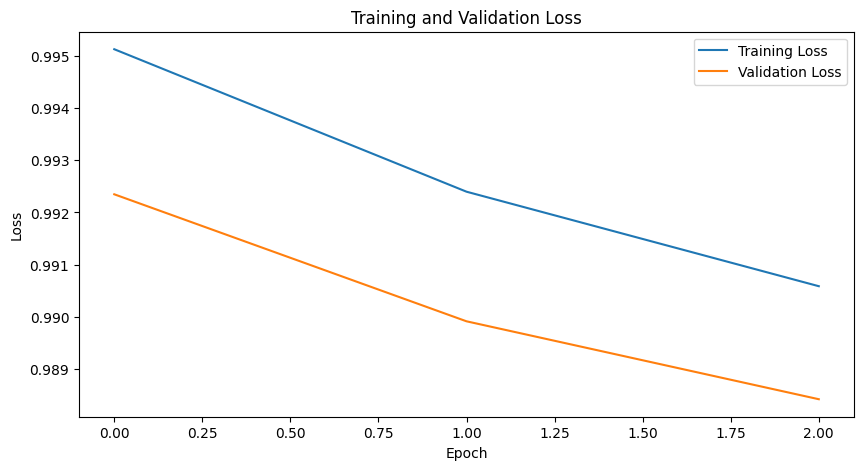

In [45]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
test_dataset=test_dataset2.concatenate(test_dataset1)

In [50]:
batch_size = 4096
test_dataset=test_dataset.shuffle(batch_size)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
model3=tf.keras.models.load_model('models/merged_model.keras')

In [51]:
model3.evaluate(test_dataset)

74/74 [==============================] - 262s 2s/step - loss: 0.9896 - mae: 0.9406


[0.9896445870399475, 0.9406413435935974]

In [35]:
model1.save('models/user_model.keras')

In [36]:
model2.save('models/anime_model.keras')

In [37]:
model3.save('models/merged_model.keras')